In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import partial
from scipy import stats
import pickle

import tensorflow as tf

2023-06-08 20:34:45.052182: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 20:34:48.104747: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-06-08 20:34:48.104900: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [ ]:
# Comment out, if you want tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM

In [4]:
from bayesflow.networks import InvertibleNetwork
from bayesflow.coupling_networks import CouplingLayer
from bayesflow.amortizers import AmortizedLikelihood, AmortizedPosterior, AmortizedPosteriorLikelihood
from bayesflow.trainers import Trainer
from bayesflow import default_settings
from bayesflow.helper_functions import build_meta_dict
from bayesflow.diagnostics import plot_sbc_ecdf, plot_sbc_histograms, plot_losses
from bayesflow.computational_utilities import maximum_mean_discrepancy

In [5]:
from assets.data_loader import load_data

In [6]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    'text.latex.preamble' : r'\usepackage{{amsmath}}'
})

# Generative Model Setup

In [7]:
alpha_f = (0.7**2)*((1-0.7)/(0.17**2) - (1-0.7))
beta_f = alpha_f*(1/0.7 - 1)


def prior_sir():
    """
    Implements batch sampling from a stationary prior over the parameters
    of the non-stationary SIR model.
    """
    
    t1 = np.random.normal(loc=8, scale=3)
    t2 = np.random.normal(loc=15, scale=1)
    t3 = np.random.normal(loc=22, scale=1)
    t4 = np.random.normal(loc=66, scale=1) 
    delta_t1 = np.random.lognormal(mean=np.log(3), sigma=0.3)
    delta_t2 = np.random.lognormal(mean=np.log(3), sigma=0.3)
    delta_t3 = np.random.lognormal(mean=np.log(3), sigma=0.3)
    delta_t4 = np.random.lognormal(mean=np.log(3), sigma=0.3)
    lambd0 = np.random.lognormal(mean=np.log(1.2), sigma=0.5)
    lambd1 = np.random.lognormal(mean=np.log(0.6), sigma=0.5)
    lambd2 = np.random.lognormal(mean=np.log(0.3), sigma=0.5)
    lambd3 = np.random.lognormal(mean=np.log(0.1), sigma=0.5)
    lambd4 = np.random.lognormal(mean=np.log(0.1), sigma=0.5)
    mu = np.random.lognormal(mean=np.log(1/8), sigma=0.2)
    f_i = np.random.beta(a=alpha_f, b=beta_f)
    phi_i = stats.vonmises(kappa=0.01).rvs()
    f_r = np.random.beta(a=alpha_f, b=beta_f)
    phi_r = stats.vonmises(kappa=0.01).rvs()
    f_d = np.random.beta(a=alpha_f, b=beta_f)
    phi_d = stats.vonmises(kappa=0.01).rvs()
    D_i = np.random.lognormal(mean=np.log(8), sigma=0.2)
    D_r = np.random.lognormal(mean=np.log(8), sigma=0.2)
    D_d = np.random.lognormal(mean=np.log(8), sigma=0.2)
    E0 = np.random.gamma(shape=2, scale=30)
    scale_I = np.random.gamma(shape=1, scale=5)
    scale_R = np.random.gamma(shape=1, scale=5)
    scale_D = np.random.gamma(shape=1, scale=5)
    return [t1, t2, t3, t4, delta_t1, delta_t2, delta_t3, delta_t4, 
            lambd0, lambd1, lambd2, lambd3, lambd4, mu, 
            f_i, phi_i, f_r, phi_r, f_d, phi_d, 
            D_i, D_r, D_d, E0, scale_I, scale_R, scale_D]


def prior_secir():
    """
    Implements batch sampling from a stationary prior over the parameters
    of the non-stationary SIR model.
    """
    
    alpha = np.random.uniform(low=0.005, high=0.9)
    beta = np.random.lognormal(mean=np.log(0.25), sigma=0.3)
    gamma = np.random.lognormal(mean=np.log(1/6.5), sigma=0.5)
    eta = np.random.lognormal(mean=np.log(1/3.2), sigma=0.3)
    theta = np.random.uniform(low=1/14, high=1/3)
    delta = np.random.uniform(low=0.01, high=0.3)
    d = np.random.uniform(low=1/14, high=1/3)
    return [alpha, beta, gamma, eta, theta, delta, d]

def calc_lambda_array(sim_lag, lambd0, lambd1, lambd2, lambd3, lambd4, 
                      t1, t2, t3, t4, delta_t1, delta_t2, delta_t3, delta_t4, T):
    """Computes the array of time-varying contact rates/transimission probabilities."""
    
    # Array of initial lambdas
    lambd0_arr = np.array([lambd0] * (t1+sim_lag))
    
    # Compute lambd1 array
    if delta_t1 == 1:
        lambd1_arr = np.array([lambd1] * (t2-t1))
    else:
        lambd1_arr = np.linspace(lambd0, lambd1, delta_t1)
        lambd1_arr = np.append(lambd1_arr, [lambd1] * (t2-t1-delta_t1))
        
    # Compute lambd2 array
    if delta_t2 == 1:
        lambd2_arr = np.array([lambd2] * (t3-t2))
    else:
        lambd2_arr = np.linspace(lambd1, lambd2, delta_t2)
        lambd2_arr = np.append(lambd2_arr, [lambd2] * (t3-t2-delta_t2))
        
    # Compute lambd3 array
    if delta_t3 == 1:
        lambd3_arr = np.array([lambd3] * (t4-t3))
    else:
        lambd3_arr = np.linspace(lambd3, lambd4, delta_t3)
        lambd3_arr = np.append(lambd3_arr, [lambd3] * (t4-t3-delta_t3))
        
    # Compute lambd4 array
    if delta_t4 == 1:
        lambd4_arr = np.array([lambd4] * (T-t4))
    else:
        lambd4_arr = np.linspace(lambd3, lambd4, delta_t4)
        lambd4_arr = np.append(lambd4_arr, [lambd4] * (T-t4-delta_t4))
    
    return np.r_[lambd0_arr, lambd1_arr, lambd2_arr, lambd3_arr, lambd4_arr]

def non_stationary_SEICR(params_sir, params_secir, N, T, sim_diff=16, observation_model=True):
    """
    Performs a forward simulation from the stationary SIR model.
    """
    
    # Extract parameters 
    t1, t2, t3, t4, delta_t1, delta_t2, delta_t3, delta_t4, lambd0, lambd1, lambd2, lambd3, lambd4, mu, f_i, phi_i, f_r, phi_r, f_d, phi_d, delay_i, delay_r, delay_d, E0, scale_I, scale_R, scale_D = params_sir
    alpha, beta, gamma, eta, theta, delta, d = params_secir
    
    # Round integer parameters
    t1, t2, t3, t4 = int(round(t1)), int(round(t2)), int(round(t3)), int(round(t4))
    delta_t1, delta_t2, delta_t3, delta_t4 = int(round(delta_t1)), int(round(delta_t2)), int(round(delta_t3)), int(round(delta_t4))
    E0 = max(1, np.round(E0)) 
    delay_i = int(round(delay_i)) 
    delay_r = int(round(delay_r)) 
    delay_d = int(round(delay_d)) 
    
    # Impose constraints
    assert sim_diff > delay_i
    assert sim_diff > delay_r
    assert sim_diff > delay_d
    assert t1 > 0 and t2 > 0 and t3 > 0 and t4 > 0
    assert t1 < t2 < t3 < t4
    assert delta_t1 > 0 and delta_t2 > 0 and delta_t3 > 0 and delta_t4 > 0
    assert t2 - t1 >= delta_t1 and t3 - t2 >= delta_t2 and t4-t3 >= delta_t3 and T-t4 >= delta_t4

    # Calculate lambda arrays
    # Lambda0 is the initial contact rate which will be consecutively
    # reduced via the government measures
    sim_lag = sim_diff - 1
    lambd_arr = calc_lambda_array(sim_lag, lambd0, lambd1, lambd2, lambd3, lambd4, 
                                  t1, t2, t3, t4, delta_t1, delta_t2, delta_t3, delta_t4, T)
 
    # Initial conditions
    S, E, C, I, R, D = [N-E0], [E0], [0], [0], [0], [0]
    
    # Containers
    I_news = []
    R_news = []
    D_news = []
    
    # Reported new cases
    I_data = np.zeros(T)
    R_data = np.zeros(T)
    D_data = np.zeros(T)
    fs_i = np.zeros(T)
    fs_r = np.zeros(T)
    fs_d = np.zeros(T)
 
    # Simulate T-1 tiemsteps
    for t in range(T+sim_lag):
        
        # Calculate new exposed cases
        E_new = lambd_arr[t] * ((C[t] + beta*I[t])/N)*S[t]
    
        # Remove exposed from susceptible
        S_t = S[t] - E_new
        
        # Calculate current exposed by adding new exposed and
        # subtracting the exposed becoming carriers.
        E_t = E[t] + E_new - gamma*E[t]
        
        # Calculate current carriers by adding the new exposed and subtracting
        # those who will develop symptoms and become detected and those who
        # will go through the disease asymptomatically.
        C_t = C[t] + gamma*E[t] - (1-alpha)*eta*C[t] - alpha*theta*C[t]
        
        # Calculate current infected by adding the symptomatic carriers and 
        # subtracting the dead and recovered. The newly infected are just the 
        # carriers who get detected.
        I_t = I[t] + (1-alpha)*eta*C[t] - (1-delta)*mu*I[t] - delta*d*I[t]
        I_new = (1-alpha)*eta*C[t]
        
        # Calculate current recovered by adding the symptomatic and asymptomatic
        # recovered. The newly recovered are only the detected recovered
        R_t = R[t] + alpha*theta*C[t] + (1-delta)*mu*I[t]
        R_new = (1-delta)*mu*I[t]
        
        # Calculate the current dead
        D_t = D[t] + delta*d*I[t]
        D_new = delta*d*I[t]
        
        # Ensure some numerical onstraints
        S_t = np.clip(S_t, 0, N)
        E_t = np.clip(E_t, 0, N)
        C_t = np.clip(C_t, 0, N)
        I_t = np.clip(I_t, 0, N)
        R_t = np.clip(R_t, 0, N)
        D_t = np.clip(D_t, 0, N)
        
        # Keep track of process over time
        S.append(S_t)
        E.append(E_t)
        C.append(C_t)
        I.append(I_t)
        R.append(R_t)
        D.append(D_t)
        I_news.append(I_new)
        R_news.append(R_new)
        D_news.append(D_new)
        
        # From here, start adding new cases with delay D
        # Note, we assume the same delay
        if t >= sim_lag:
            
            # Compute lags and add to data arrays
            fs_i[t-sim_lag] = (1-f_i)*(1 - np.abs( np.sin( (np.pi/7) * (t-sim_lag) - 0.5*phi_i)) )
            fs_r[t-sim_lag] = (1-f_r)*(1 - np.abs( np.sin( (np.pi/7) * (t-sim_lag) - 0.5*phi_r)) )
            fs_d[t-sim_lag] = (1-f_d)*(1 - np.abs( np.sin( (np.pi/7) * (t-sim_lag) - 0.5*phi_d)) )
            I_data[t-sim_lag] = I_news[t-delay_i]
            R_data[t-sim_lag] = R_news[t-delay_r]
            D_data[t-sim_lag] = D_news[t-delay_d]
            
    # Compute weekly modulation
    I_data = (1-fs_i) * I_data
    R_data = (1-fs_r) * R_data
    D_data = (1-fs_d) * D_data
    
    # Add noise
    I_data = stats.t(df=4, loc=I_data, scale=np.sqrt(I_data)*scale_I).rvs()
    R_data = stats.t(df=4, loc=R_data, scale=np.sqrt(R_data)*scale_R).rvs()
    D_data = stats.t(df=4, loc=D_data, scale=np.sqrt(D_data)*scale_D).rvs()
    
    if observation_model:
        return np.stack((I_data, R_data, D_data)).T
    return np.stack((S, E, I, C, R, D)).T

def simulate_given_params(n_sim, params,  N, T, sim_diff=21, observation_model=True):
    """Simulated multiple trajectories from the full model given a fixed parameter configuration."""
    
    x = []
    theta1, theta2 = params[:-7], params[-7:]
    for _ in range(n_sim):
        x_i = non_stationary_SEICR(theta1, theta2, N=N, T=T, sim_diff=sim_diff, observation_model=observation_model)
        x.append(x_i)
    return np.clip(np.array(x), 0, np.inf)

# Generator Function

In [13]:
def data_generator(batch_size, T=None, N=None, sim_diff=21, seed=None, scale=1000):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------
    
    Output:
    forward_dict : dict
        The expected outputs for a BayesFlow pipeline
    """
    
    if seed is not None:
        np.random.seed(seed)
        
    # Generate data
    # x is a np.ndarray of shape (batch_size, n_obs, x_dim)
    x = []
    theta = []
    for i in range(batch_size):
        
        # Reject meaningless simulaitons
        x_i = None
        while x_i is None:
            try:
                theta1 = prior_sir()
                theta2 = prior_secir()
                x_i = non_stationary_SEICR(theta1, theta2, N, T, sim_diff=sim_diff)
            except:
                 pass
        # Simulate SECIR
        x.append(x_i)
        theta.append(theta1 + theta2)
        
    # Clip negative and normalize
    x = np.clip(np.array(x), 0.0, np.inf) / scale
    theta = np.array(theta)

    forward_dict = {
        'prior_draws': theta,
        'sim_data': x
    }
    return forward_dict

In [14]:
np.random.seed(42)
theta1_s = np.array([prior_sir() for _ in range(50000)])
theta2_s = np.array([prior_secir() for _ in range(50000)])
theta1_mu = np.mean(theta1_s, axis=0, keepdims=True)
theta2_mu = np.mean(theta2_s, axis=0, keepdims=True)
theta1_std = np.std(theta1_s, axis=0, keepdims=True)
theta2_std = np.std(theta2_s, axis=0, keepdims=True)

In [10]:
theta_mu = np.c_[theta1_mu, theta2_mu]
theta_std = np.c_[theta1_std, theta2_std]

# MultiConv Summary Network - Used for Amortized Posterior
Use same network as in our initial paper https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1009472, but could also use the simple `SequentialNetwork` interface.

In [12]:
class MultiConvLayer(tf.keras.Model):
    """Implements an inception-inspired conv layer using different kernel sizes"""
    def __init__(self, n_filters=32, strides=1):
        super(MultiConvLayer, self).__init__()
        
        self.convs = [
            tf.keras.layers.Conv1D(n_filters//2, kernel_size=f, strides=strides, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform')
            for f in range(2, 8)
        ]
        self.dim_red = tf.keras.layers.Conv1D(n_filters, 1, 1, 
                                              activation='relu', kernel_initializer='glorot_uniform')
        
    def call(self, x):
        """x is a timeseries of dimensions B timestamps, n_features"""
        
        out = tf.concat([conv(x) for conv in self.convs], axis=-1)
        out = self.dim_red(out)
        return out
    
    
class MultiConvNet(tf.keras.Model):
    """Implements an inception-inspired conv layer using different kernel sizes"""
    def __init__(self, n_layers=3, n_filters=64, strides=1):
        super(MultiConvNet, self).__init__()
        
        self.net = tf.keras.Sequential([
            MultiConvLayer(n_filters, strides)
            for _ in range(n_layers)
        ])
        
        self.lstm = LSTM(n_filters)
        
    def call(self, x, **args):
        """x is a timeseries of dimensions B timestamps, n_features"""
        
        out = self.net(x)
        out = self.lstm(out)
        return out
    
    
class SummaryNet(tf.keras.Model):
    def __init__(self, n_summary):
        super(SummaryNet, self).__init__()
        self.net_I = MultiConvNet(n_filters=n_summary//3)
        self.net_R = MultiConvNet(n_filters=n_summary//3)
        self.net_D = MultiConvNet(n_filters=n_summary//3)
    
    @tf.function
    def call(self, x, **args):
        """x is a timeseries of dimensions B timestamps, n_features"""
        
        x = tf.split(x, 3, axis=-1)
        x_i = self.net_I(x[0])
        x_r = self.net_R(x[1])
        x_d = self.net_D(x[2])
        return tf.concat([x_i, x_r, x_d], axis=-1)

# Recurrent Memory
This network will be used by the likelihood network to represent the temporal structure of the data. Some boilerplate is needed due to the use of teacher forcing.

In [15]:
class MemoryNetwork(tf.keras.Model):
    def __init__(self, meta):
        super(MemoryNetwork, self).__init__()
        
        self.gru = GRU(meta['n_hidden'], return_sequences=True, return_state=True)
        self.h = meta['n_hidden']
        self.n_params = meta['n_params']
    
    @tf.function
    def call(self, target, condition):
        """ Performs a forward pass through the network. 
        
        Params:
        -------
        target    : tf.Tesnor of shape (batch_size, time_stes, dim)
            The time-dependent signal to process.
        condition : tf.Tensor of shape (batch_size, cond_dim)
            The conditional (static) variables, e.g., parameters.
        """
        shift_target = target[:, :-1, :]
        init = tf.zeros((target.shape[0], 1, target.shape[2]))
        inp_teacher = tf.concat([init, shift_target], axis=1)
        inp_teacher_c = tf.concat([inp_teacher, condition], axis=-1)
        out, _ = self.gru(inp_teacher_c)
        return out
    
    def step_loop(self, target, condition, state):
        out, new_state = self.gru(tf.concat([target, condition], axis=-1), initial_state=state)
        return out, new_state

# Invertible Network with Memory
This is still not an official part of the BayesFlow lib, since we may find a better architecture anytime. Works best for now.

In [48]:
class InvertibleNetworkWithMemory(tf.keras.Model):
    """Implements a chain of conditional invertible blocks for Bayesian parameter inference."""

    def __init__(self, 
                 num_params, 
                 num_coupling_layers=4, 
                 coupling_settings=None, 
                 coupling_design='affine',
                 permutation="fixed", 
                 use_act_norm=True, 
                 act_norm_init=None, 
                 use_soft_flow=False, 
                 soft_flow_bounds=(1e-3, 5e-2)
        ):
        """Initializes a custom invertible network with recurrent memory."""

        super().__init__()

        # Create settings dict for coupling layer
        settings = dict(
            latent_dim=num_params,
            coupling_settings=coupling_settings,
            coupling_design=coupling_design,
            permutation=permutation,
            use_act_norm=use_act_norm,
            act_norm_init=act_norm_init,
        )

        # Create sequence of coupling layers and store reference to dimensionality
        self.coupling_layers = [CouplingLayer(**settings) for _ in range(num_coupling_layers)]

        # Store attributes
        self.soft_flow = use_soft_flow
        self.soft_low = soft_flow_bounds[0]
        self.soft_high = soft_flow_bounds[1]
        self.use_act_norm = use_act_norm 
        self.latent_dim = num_params
        self.dynamic_summary_net = MemoryNetwork({'n_hidden': 256, 'n_params': 3})
        self.latent_dim = num_params

    def call(self, targets, condition, inverse=False):
        """Performs one pass through an invertible chain (either inverse or forward).

        Parameters
        ----------
        targets   : tf.Tensor
            The estimation quantities of interest, shape (batch_size, ...)
        condition : tf.Tensor
            The conditional data x, shape (batch_size, summary_dim)
        inverse   : bool, default: False
            Flag indicating whether to run the chain forward or backwards

        Returns
        -------
        (z, log_det_J)  :  tuple(tf.Tensor, tf.Tensor)
            If inverse=False: The transformed input and the corresponding Jacobian of the transformation,
            v shape: (batch_size, ...), log_det_J shape: (batch_size, ...)

        target          :  tf.Tensor
            If inverse=True: The transformed out, shape (batch_size, ...)

        Important
        ---------
        If ``inverse=False``, the return is ``(z, log_det_J)``.\n
        If ``inverse=True``, the return is ``target``.
        """
        
        if inverse:
            return self.inverse(targets, condition)
        return self.forward(targets, condition)
    
    @tf.function
    def forward(self, targets, condition, **kwargs):
        """Performs a forward pass though the chain."""

        # Add memory condition
        memory = self.dynamic_summary_net(targets, condition)
        condition = tf.concat([memory, condition], axis=-1)
        
        z = targets
        log_det_Js = []
        for layer in self.coupling_layers:
            z, log_det_J = layer(z, condition, **kwargs)
            log_det_Js.append(log_det_J)
        # Sum Jacobian determinants for all layers (coupling blocks) to obtain total Jacobian.
        log_det_J = tf.add_n(log_det_Js)
        return z, log_det_J

    @tf.function
    def inverse(self, z, condition, **kwargs):
        """Performs a reverse pass through the chain."""

        target = z
        T = z.shape[1]
        gru_inp = tf.zeros((z.shape[0], 1, z.shape[-1])) 
        state = tf.zeros((z.shape[0], self.dynamic_summary_net.h))
        outs = []
        for t in range(T):
            # One step condition
            memory, state = self.dynamic_summary_net.step_loop(gru_inp, condition[:, t:t+1, :], state)
            condition_t = tf.concat([memory, condition[:, t:t+1, :]], axis=-1)
            target_t = target[:, t:t+1, :]
            for layer in reversed(self.coupling_layers):
                target_t = layer(target_t, condition_t, inverse=True, **kwargs)
            outs.append(target_t)
            gru_inp = target_t
        return tf.concat(outs, axis=1)

# Configurator
Care is needed, since the magnitude of the observed time series can grow wildly. Probably not needed for well behaved models.

In [49]:
def configurator(forward_dict):
    """Customized preprocessing for the Covid simulator."""
    
    out = {
        'posterior_inputs': {},
        'likelihood_inputs': {}
    }
    
    # Extract data
    x = forward_dict['sim_data'].astype(np.float32)
    x_means = np.mean(x, axis=1, keepdims=True)
    x_std = np.std(x, axis=1, keepdims=True)
    x = (x - x_means) / x_std
    log_mu = np.log2(1 + x_means[:, 0, :])
    log_std = np.log2(1 + x_std[:, 0, :])
        
    # Extract params 
    p = forward_dict['prior_draws'].astype(np.float32)
    p = (p - theta_mu) / theta_std
    
    # Repeat condition
    cond = np.concatenate([p, log_mu, log_std], axis=-1)
    cond = np.stack([cond] * x.shape[1], axis=1)
    
    # Likelihood inputs
    out['likelihood_inputs']['observables'] = x.astype(np.float32)
    out['likelihood_inputs']['conditions'] = np.concatenate([cond], axis=-1).astype(np.float32)
    
    # Posterior inputs
    out['posterior_inputs']['parameters'] = p
    out['posterior_inputs']['summary_conditions'] = out['likelihood_inputs']['observables']
    out['posterior_inputs']['direct_conditions'] = np.concatenate([log_mu, log_std], axis=-1)
    
    return out

In [50]:
real_data = load_data()

In [51]:
generative_model = partial(data_generator, N=real_data['N'], T=real_data['T'])

# Amortizers

In [52]:
param_names = [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$',
               r'$\Delta t_1$', r'$\Delta t_2$', r'$\Delta t_3$', r'$\Delta t_4$',
               r'$\lambda_0$', r'$\lambda_1$', r'$\lambda_2$', r'$\lambda_3$', r'$\lambda_4$', 
               r'$\mu$', r'$A_I$', r'$\phi_I$',  r'$A_R$', r'$\phi_R$',  
               r'$A_D$', r'$\phi_D$',
               r'$L_I$', r'$L_R$', r'$L_D$', r'$E_0$', r'$\sigma_I$', r'$\sigma_R$', r'$\sigma_D$', 
               r'$\alpha$', r'$\beta$', r'$\gamma$',
               r'$\eta$', r'$\theta$', r'$\delta$', r'$d$']

In [53]:
coupling_settings = {
    'dense_args': dict(units=128, activation='swish', kernel_regularizer=None),
    'num_dense': 2,
    'dropout': False
}

In [54]:
likelihood_net = InvertibleNetworkWithMemory(num_params=3, num_coupling_layers=8, coupling_settings=coupling_settings)
posterior_net = InvertibleNetwork(num_params=len(param_names), num_coupling_layers=6, coupling_settings=coupling_settings)
summary_net = SummaryNet(n_summary=192)
amortized_posterior = AmortizedPosterior(posterior_net, summary_net, summary_loss_fun='MMD')
amortized_likelihood = AmortizedLikelihood(likelihood_net)
joint_amortizer = AmortizedPosteriorLikelihood(amortized_posterior, amortized_likelihood)

# Training

In [55]:
trainer = Trainer(
    amortizer=joint_amortizer,
    generative_model=generative_model,
    configurator=configurator,
    checkpoint_path='checkpoints/joint_mmd',
    memory=False,
    max_to_keep=1
)

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
2023-06-08 20:44:56.277362: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
INFO:root:Done.


In [59]:
# # Uncomment for training
# h = trainer.train_online(epochs=100, iterations_per_epoch=1000, batch_size=32, validation_sims=150)

# Validation

## Loss Trajectories

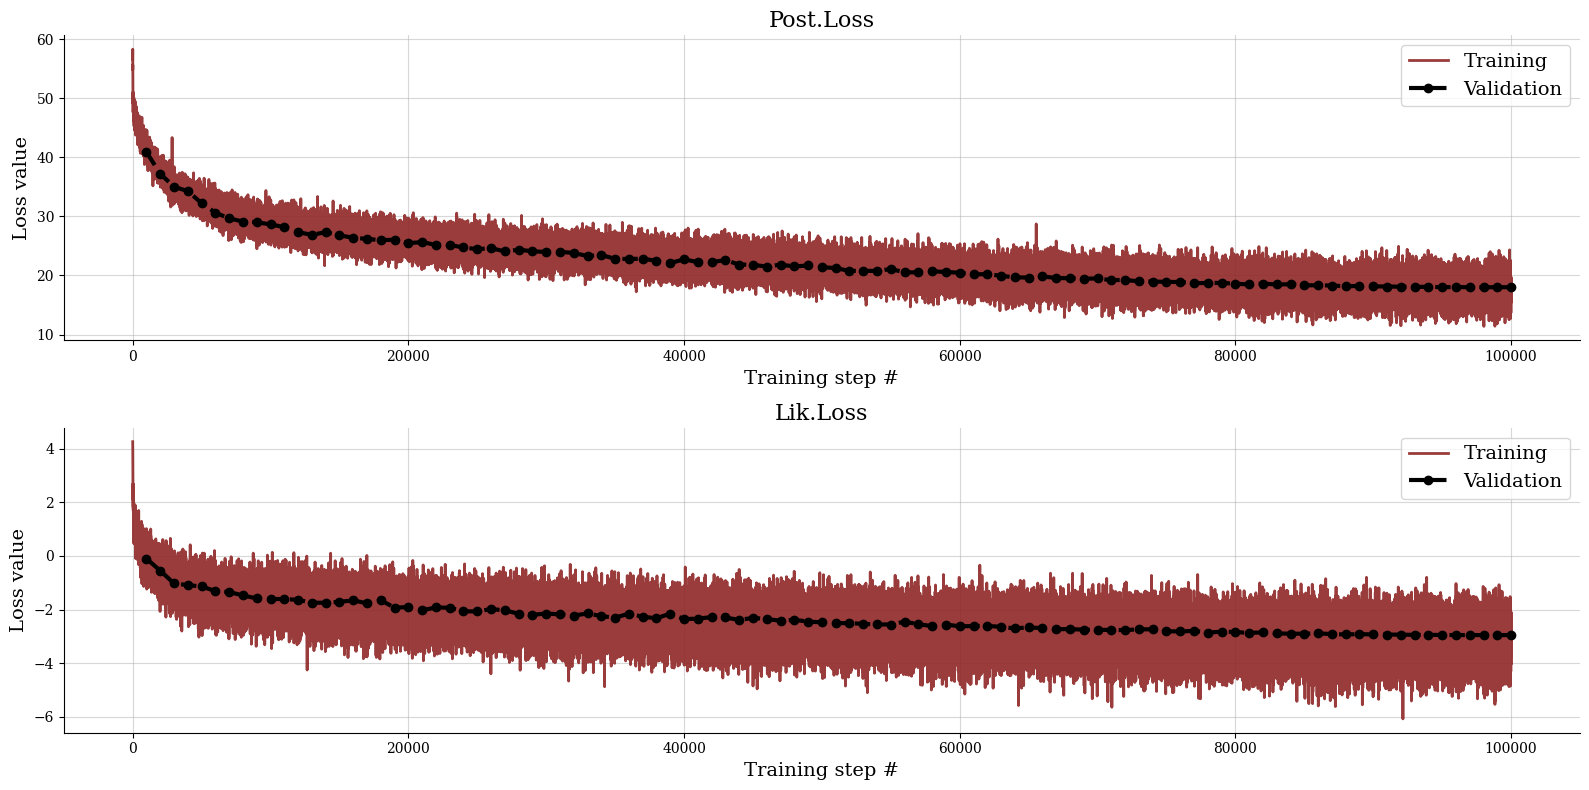

In [61]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])
f.savefig('figures/loss_history.pdf', dpi=300)

# Paper Plots

In [62]:
import matplotlib.ticker as ticker

def publication_plot(to_plot, sim_out, real_data):
    """Helper function to generate pretty simulation vs. re-simulation plots."""

    colors = ['#000080', '#008000', '#800000']
    titles = ['Infected', 'Recovered', 'Dead']
    f, axarr = plt.subplots(2, 3, figsize=(15, 9))
    time = np.arange(1, real_data['T']+1)
    sur_med = np.median(to_plot, axis=0)
    sur_q_95 = np.quantile(to_plot, axis=0, q=(0.025, 0.975))
    sur_q_50 = np.quantile(to_plot, axis=0, q=(0.25, 0.75))
    sim_med = np.median(sim_out, axis=0)
    sim_q_95 = np.quantile(sim_out, axis=0, q=(0.025, 0.975))
    sim_q_50 = np.quantile(sim_out, axis=0, q=(0.25, 0.75))

    for i, ax in enumerate(axarr.flat[:3]):
        # Surrogate outputs
        ax.plot(time, sur_med[:, i], color=colors[i], lw=4, linestyle='dotted', alpha=0.9)
        ax.fill_between(time, sur_q_50[0, :, i], sur_q_50[1, :, i], color=colors[i], alpha=0.5)
        ax.fill_between(time, sur_q_95[0, :, i], sur_q_95[1, :, i], color=colors[i], alpha=0.3)

        # General plot settings
        sns.despine(ax=ax)
        ax.grid(alpha=0.25)
        ax.set_ylabel(f'# {titles[i]}', fontsize=25) 
        ax.tick_params(axis='both', which='major', labelsize=17)
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x) + 'k'))

    for i, ax in enumerate(axarr.flat[3:]):
        # Surrogate outputs
        ax.plot(time, sim_med[:, i], color=colors[i], lw=4, linestyle='dotted', alpha=0.9, label='Median')
        ax.fill_between(time, sim_q_50[0, :, i], sim_q_50[1, :, i], color=colors[i], alpha=0.5, label='50%-CI')
        ax.fill_between(time, sim_q_95[0, :, i], sim_q_95[1, :, i], color=colors[i], alpha=0.3, label='95%-CI')

        # General plot settings
        sns.despine(ax=ax)
        ax.grid(alpha=0.25)
        ax.set_xlabel('Time (days)', fontsize=25)
        ax.set_ylabel(f'# {titles[i]}', fontsize=25) 
        ax.tick_params(axis='both', which='major', labelsize=17)
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x) + 'k'))
        # ax.legend(fontsize=15)

    axarr[0, 0].text(-0.42, 0.5, "Surrogate",
        horizontalalignment="left",
        verticalalignment="center",
        rotation=90,
        fontsize=30,
        transform=axarr[0, 0].transAxes
    )

    axarr[1, 0].text(-0.42, 0.5, "Simulator",
        horizontalalignment="left",
        verticalalignment="center",
        rotation=90,
        fontsize=30,
        transform=axarr[1, 0].transAxes
    )
    f.tight_layout()
    return f

### Teaser Figure

In [63]:
# Set number of simulated trajectories
n_trajectories = 1000

# Simulate data and format for likelihood network

# Generate from prior for new figure (Uncomment)
# out = generative_model(1)
# pars = np.array([out['prior_draws'][0].astype(np.float32)] * n_trajectories)

# Or load for paper figure (Comment out)
# Note, that the parameters are already repeated n_trajectories = 1000 times over axis = 0
pars = np.load('assets/parameters.npy')

# Generate simulations from the true simulator given parameters
sim_out = simulate_given_params(n_trajectories, pars[0], real_data['N'], real_data['T']) / 1000
net_in = configurator({'sim_data': sim_out, 'prior_draws': pars})
means_out = np.mean(sim_out, axis=1)
stds_out = np.std(sim_out, axis=1)

# Generate surrogate simulations given parameters
net_out = amortized_likelihood.sample(net_in['likelihood_inputs'], real_data['T'])

In [64]:
# Create summary representations
rep_sim = summary_net(net_in['posterior_inputs']['summary_conditions'])
rep_sur = summary_net(net_out)

# Compute individual MMDs
total_mmd = maximum_mean_discrepancy(rep_sim, rep_sur)
mmds_all = [maximum_mean_discrepancy(rep_sim, rep_sur[i:(i+1), :]).numpy() for i in range(n_trajectories)]

# Remove 1% with a highest MMD - posterior net criticizes likelihood net
idx_good = np.argsort(mmds_all)[:990]

to_plot = net_out[idx_good] * stds_out[idx_good, np.newaxis, :] + means_out[idx_good, np.newaxis, :]

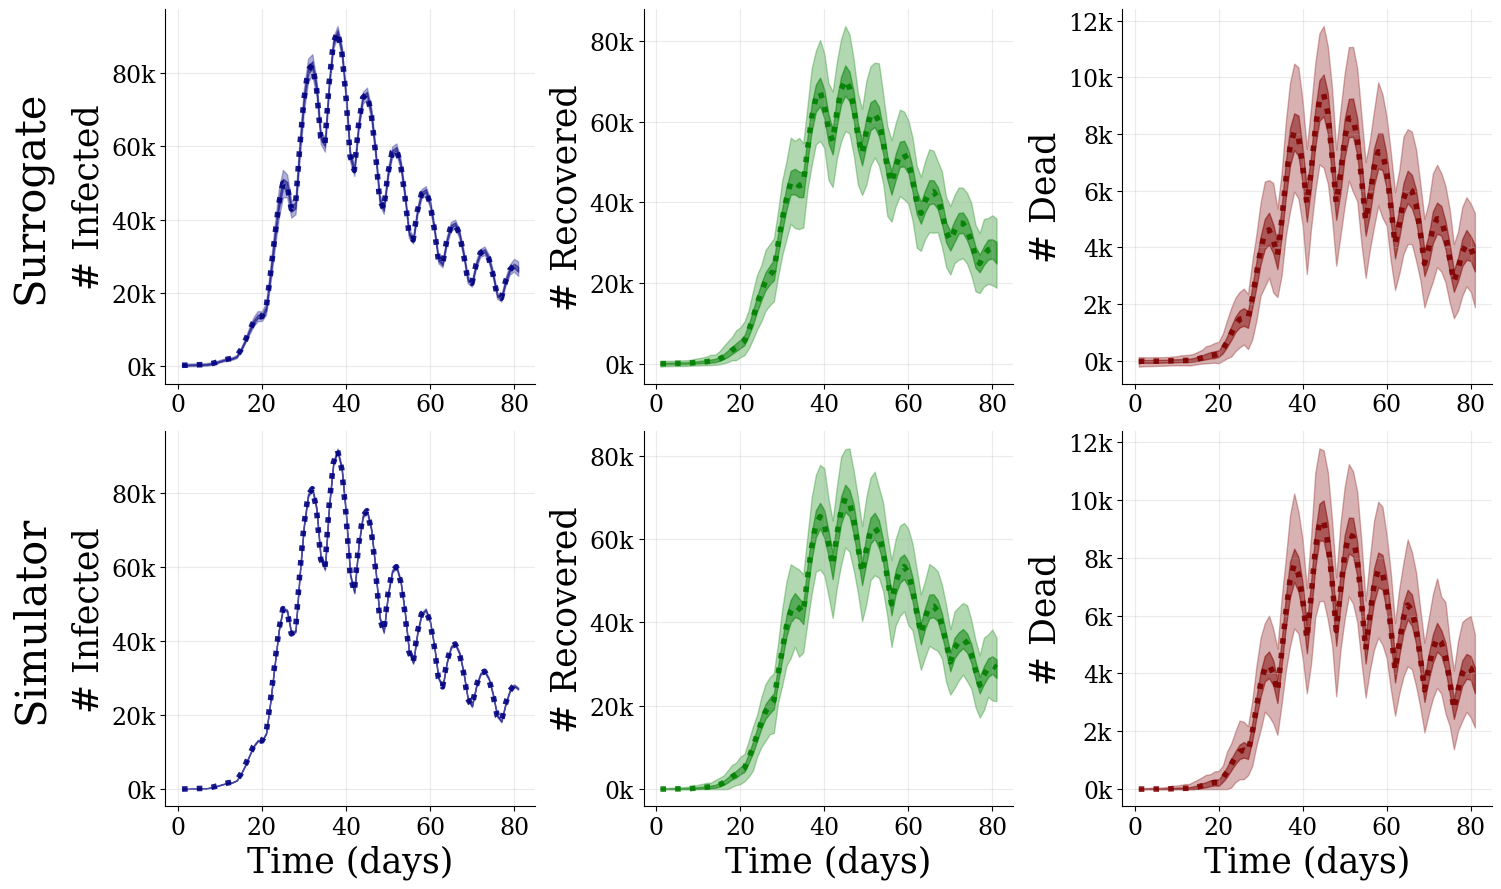

In [65]:
f = publication_plot(to_plot, sim_out, real_data)
# f.savefig('figures/covid_teaser_nolegend.pdf', dpi=300)

### Appendix Plots

In [ ]:
n_sims = 10
n_trajectories = 1000

for sim in range(n_sims):
    # Sample from simulator
    out = generative_model(1)
    pars = np.array([out['prior_draws'][0].astype(np.float32)] * n_trajectories)

    # Generate simulations from the true simulator given parameters
    sim_out = simulate_given_params(n_trajectories, pars[0], real_data['N'], real_data['T']) / 1000
    net_in = configurator({'sim_data': sim_out, 'prior_draws': pars})
    means_out = np.mean(sim_out, axis=1)
    stds_out = np.std(sim_out, axis=1)

    # Generate surrogate simulations given parameters
    net_out = amortized_likelihood.sample(net_in['likelihood_inputs'], real_data['T'])

    # Create summary representations and compute MMDs
    rep_sim = summary_net(net_in['posterior_inputs']['summary_conditions'])
    rep_sur = summary_net(net_out)
    total_mmd = maximum_mean_discrepancy(rep_sim, rep_sur)
    mmds_all = [maximum_mean_discrepancy(rep_sim, rep_sur[i:(i+1), :]).numpy() for i in range(n_trajectories)]

    # Remove 1% with a highest MMD - posterior net criticizes likelihood net
    idx_good = np.argsort(mmds_all)[:990]
    to_plot = net_out[idx_good] * stds_out[idx_good, np.newaxis, :] + means_out[idx_good, np.newaxis, :]
    
    f = publication_plot(to_plot, sim_out, real_data)
    f.savefig(f'figures/surrogate_{sim}.pdf', dpi=300, bbox_inches='tight')

# Calibration

In [73]:
n_test_cal = 1000
n_posterior_samples = 100
gen_out = generative_model(n_test_cal)

In [74]:
# Configure simulator output
conf = configurator(gen_out)

# Obtain surrogate time series given prior draws
means_out = np.mean(gen_out['sim_data'], axis=1)
stds_out = np.std(gen_out['sim_data'], axis=1)
x_sim_s_u = joint_amortizer.sample_data(conf['likelihood_inputs'], n_samples=real_data['T']) 
x_sim_s = x_sim_s_u * stds_out[:, np.newaxis, :] + means_out[:, np.newaxis, :]

# Configure surrogate outputs
conf_s = configurator({'sim_data': x_sim_s, 'prior_draws': gen_out['prior_draws']})

# Sample from approx. posteriors given surrogate simulator outputs
post_samples_s = joint_amortizer.sample_parameters(conf_s['posterior_inputs'], n_samples=n_posterior_samples)

# Sample from approx. posteriors given true simulator outputs
post_samples_t = joint_amortizer.sample_parameters(conf['posterior_inputs'], n_samples=n_posterior_samples)

# Extract prior samples
prior_samples = conf['posterior_inputs']['parameters']

## Joint Calibration

In [75]:
from assets.custom_plots import plot_sbc_ecdf_appendix

### Posterior

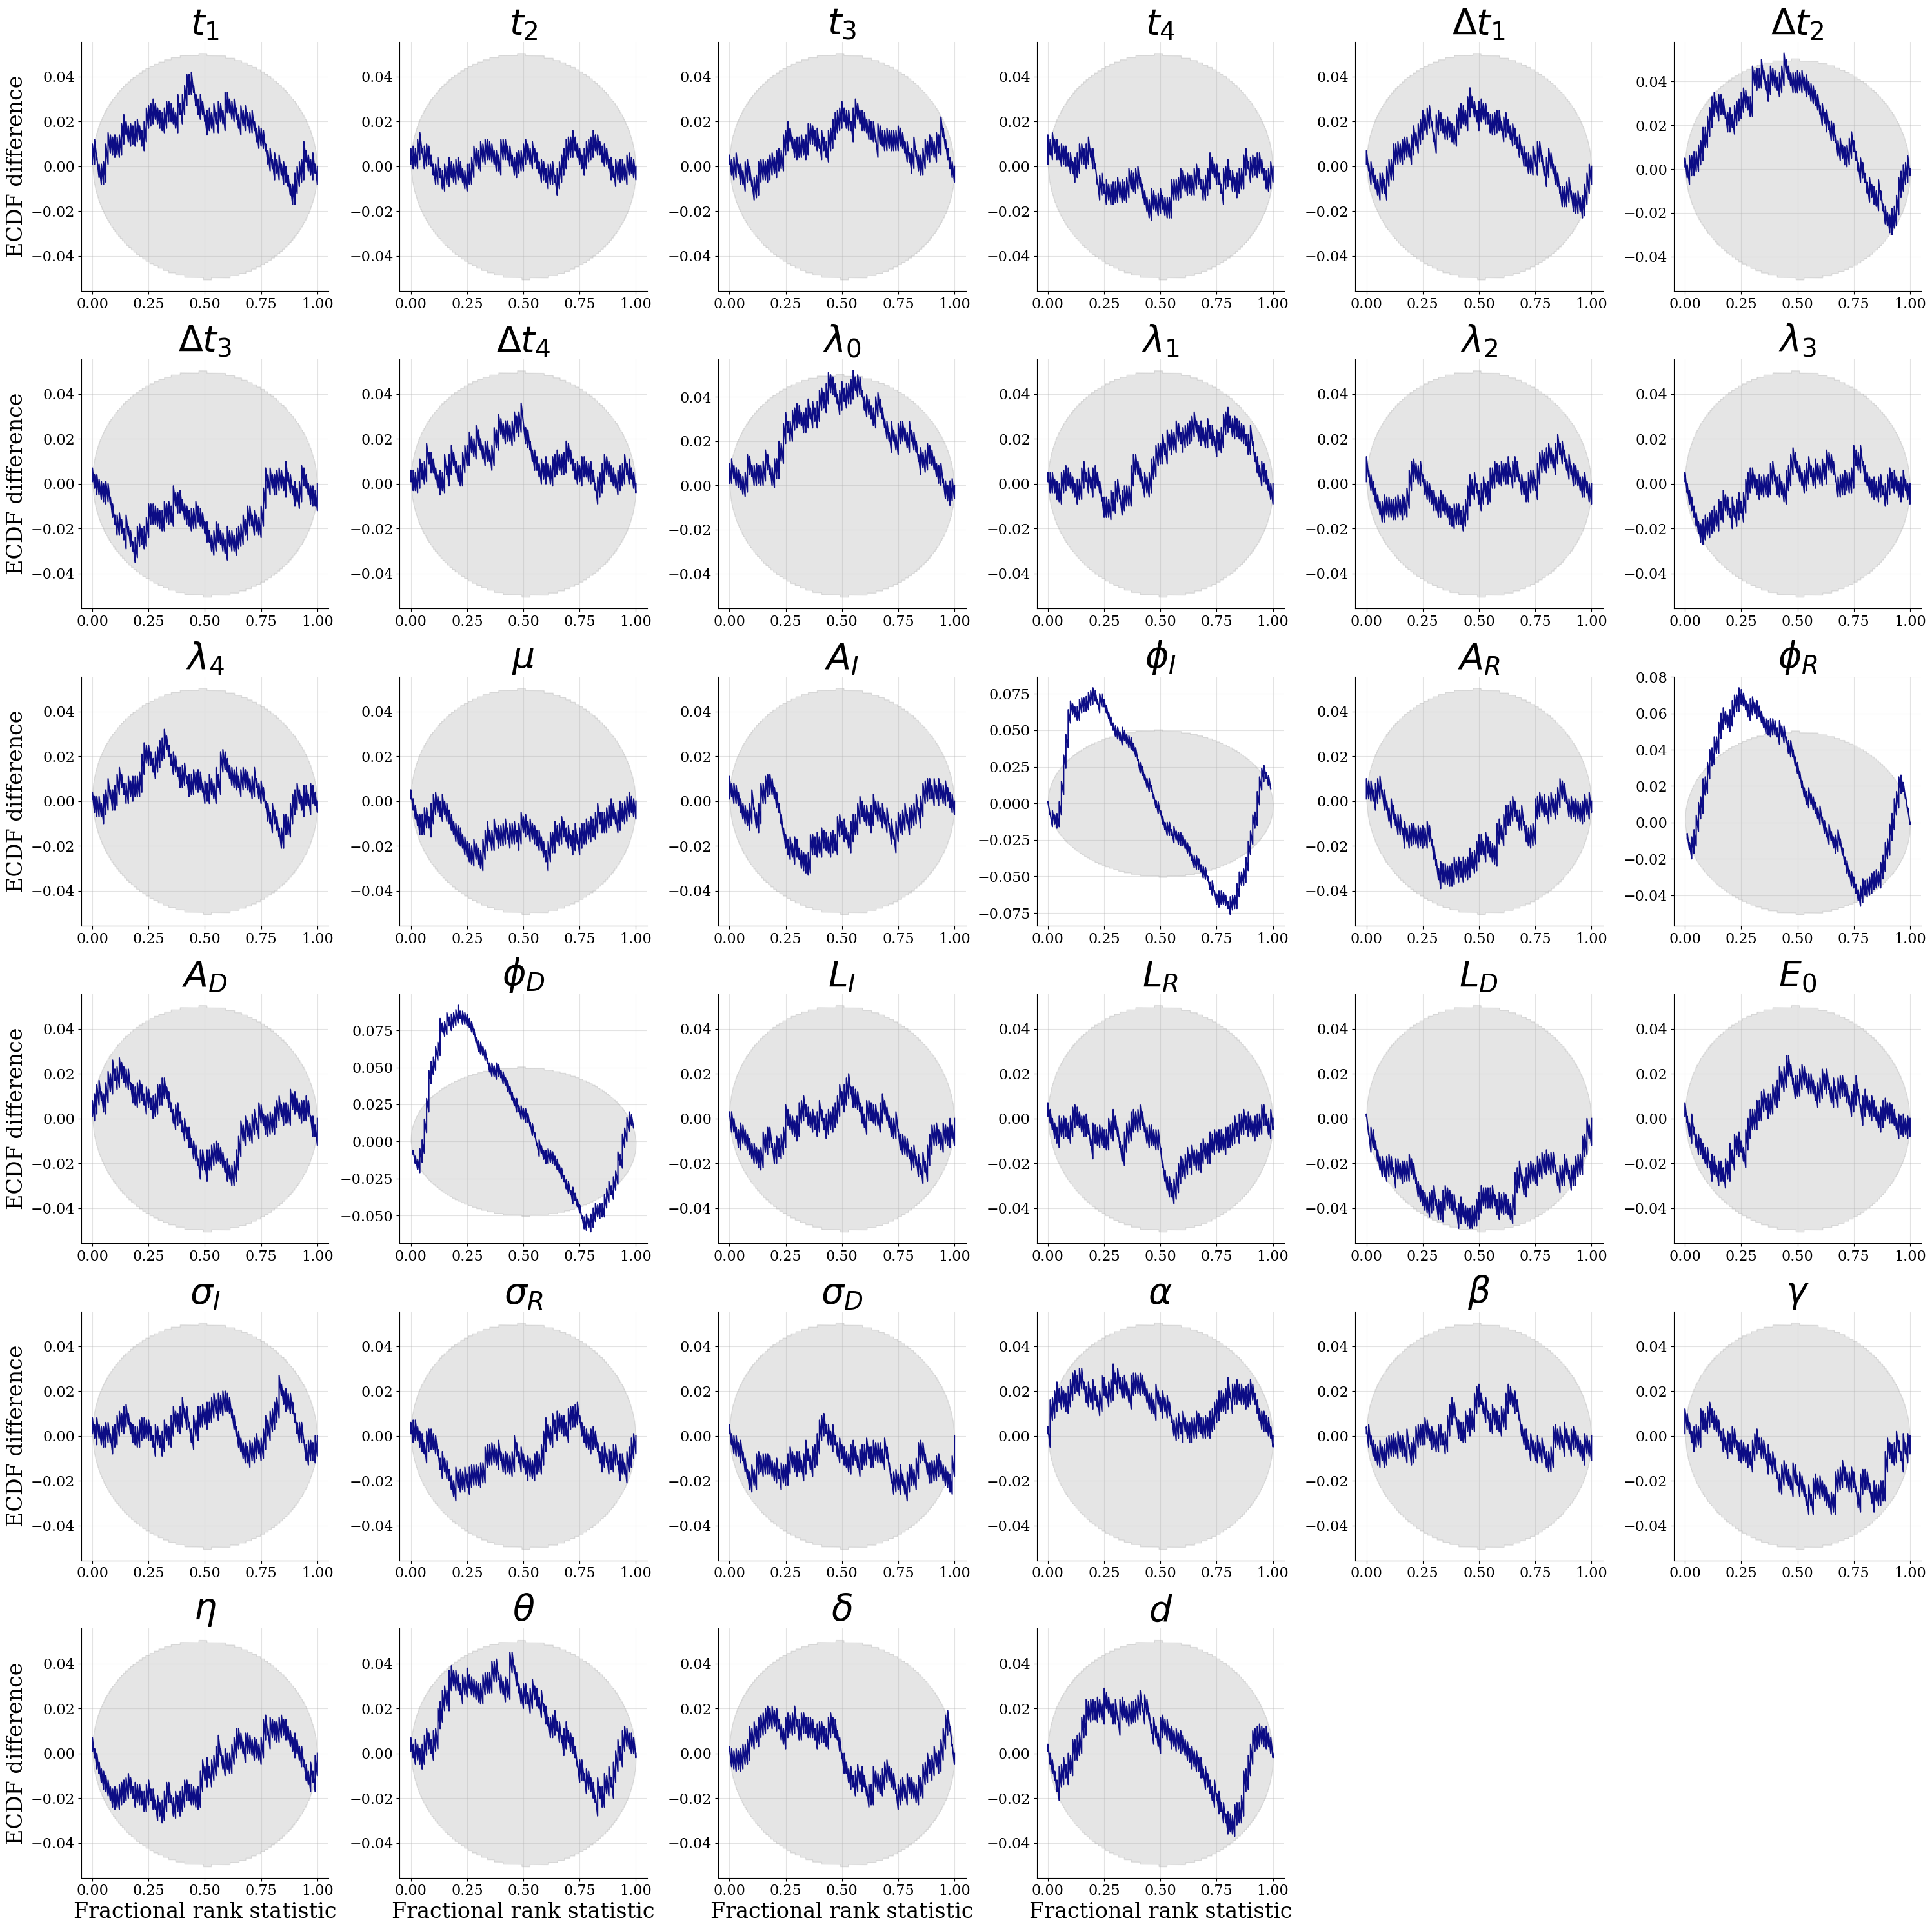

In [76]:
f = plot_sbc_ecdf_appendix(post_samples_t, prior_samples, param_names=param_names, difference=True, 
                  rank_ecdf_color='#000080', label_fontsize=24, legend_fontsize=24, title_fontsize=40)
f.savefig('figures/sbc_post_ecdf.pdf', dpi=300)

### Joint

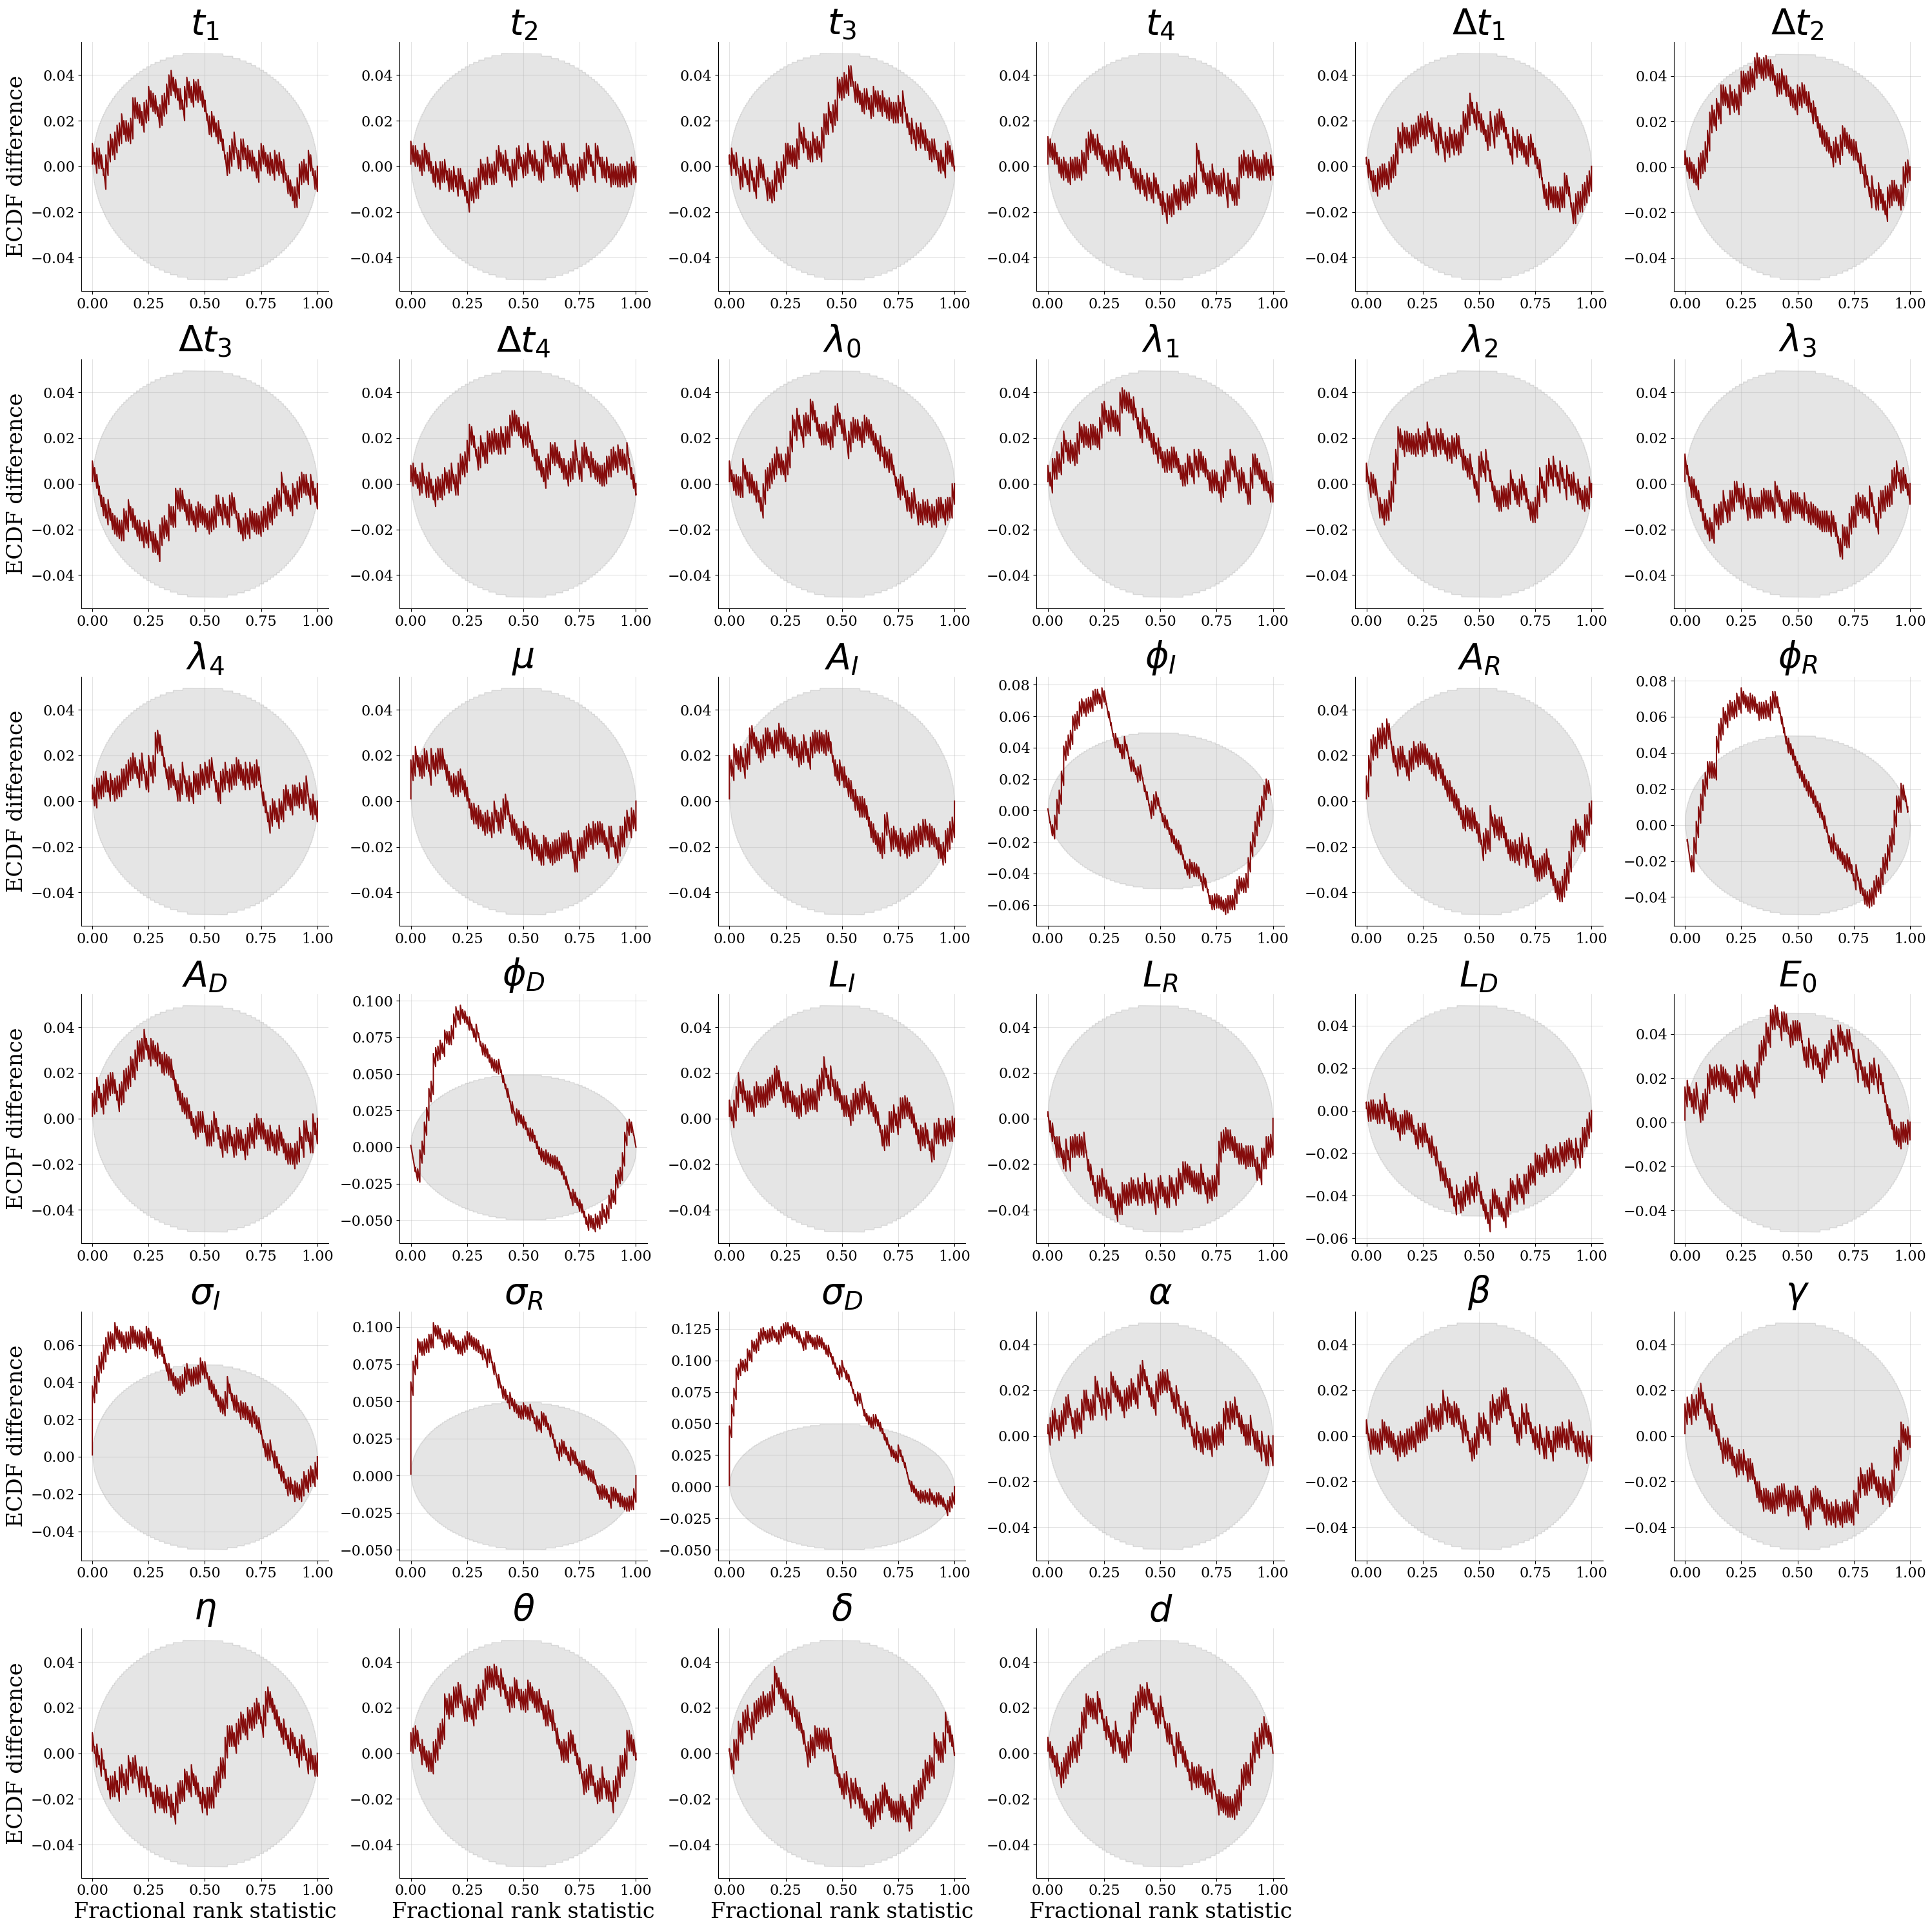

In [77]:
f = plot_sbc_ecdf_appendix(post_samples_s, prior_samples, param_names=param_names, difference=True, 
                  rank_ecdf_color='#800000', label_fontsize=24, legend_fontsize=24, title_fontsize=40)
f.savefig('figures/sbc_joint_ecdf.pdf', dpi=300)